# Cohort Selection Using MIDRC Temporal COVID Test Data
---
by Chris Meyer, PhD

Manager of Data and User Services at the Center for Translational Data Science at the University of Chicago

August 2022

---
This Jupyter notebook tutorial demonstrates how to use the MIDRC data commons' APIs to access imaging study and COVID-19 test data, how to use temporal properties in those data to select a cohort of COVID-19 positive imaging studies, and how to access those image files.

# Python packages:

In [1]:
# The packages below may be necessary for users to install according to the imports necessary in the subsequent cells.

#!pip install --upgrade pandas
#!pip install --upgrade --ignore-installed PyYAML
#!pip install --upgrade pip
#!pip install --upgrade gen3 --user --upgrade
#!pip install cdiserrors
#!pip install --upgrade pydicom

# Import Python Packages and scripts

In [2]:
# Import Python Packages and scripts
import pandas as pd
import sys, os, webbrowser
import gen3
import pydicom
import matplotlib.pyplot as plt

from gen3.submission import Gen3Submission
from gen3.auth import Gen3Auth
from gen3.index import Gen3Index
from gen3.query import Gen3Query

In [3]:
# Import some custom Python scripts from personal GitHub repo
# change these directory paths to reflect your local working directory

home_dir = "/Users/christopher" 
demo_dir = "{}/Documents/Notes/MIDRC/tutorials".format(home_dir)

os.chdir(demo_dir)

os.system("wget https://raw.githubusercontent.com/cgmeyer/gen3sdk-python/master/expansion/expansion.py -O {}/expansion.py".format(demo_dir))
%run expansion.py


In [4]:
# Initiate instances of the Gen3 SDK Classes using credentials file for authentication
# Change the directory path in "cred" to reflect the location of your credentials file.

api = "https://data.midrc.org"
cred = "{}/Downloads/midrc-credentials.json".format(home_dir)
auth = Gen3Auth(api, refresh_file=cred) # authentication class
sub = Gen3Submission(api, auth) # submission class
query = Gen3Query(auth) # query class
exp = Gen3Expansion(api,auth,sub) # class with some custom scripts
exp.get_project_ids()


Getting all project_ids you have access to in the data commons.
['Open-A1', 'Open-A1_PETAL_REDCORAL', 'Open-R1', 'TCIA-RICORD']


/Users/christopher/Documents/Notes/MIDRC/tutorials/expansion.py:213: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  df = json_normalize(res["data"]["project"])


['Open-A1', 'Open-A1_PETAL_REDCORAL', 'Open-R1', 'TCIA-RICORD']


## How can one associate the date of an imaging exam with the date of COVID-19 test results for a patient?
---

Specific dates are not allowed in the MIDRC data commons, but given a single "index_event" for a case, "days to X from index event" properties are provided.

For example, one can query or export the imaging_study node, which has "days_to_study", and the measurement node, which has "test_days_from_index", and merge into a single table on "case_ids" (the unique, de-identified patient identifiers) to create a temporal timeline of imaging studies and COVID-19 tests for a cohort of patients.


## Export metadata using submission API
---
Here we'll utilize the MIDRC submission API to export all the imaging study and measurement (COVID-19 tests) data using the ["get_node_tsvs" function](https://github.com/cgmeyer/gen3sdk-python/blob/2aecc6575b22f9cca279b650914971dd6723a2ce/expansion/expansion.py#L219), which is a wrapper to export and merge all the records in a node across each project in the data commons using the [Gen3SDK](https://github.com/uc-cdis/gen3sdk-python/) function [Gen3Submission.export_node()](https://github.com/uc-cdis/gen3sdk-python/blob/5d7b5270ff11cf7037f211cf01e410d8e73d6b84/gen3/submission.py#L361).

In [5]:
# Export all the records in the imaging_study node
st = exp.get_node_tsvs(node='imaging_study')
print('\nrows:{}, columns:{}'.format(st.shape[0],st.shape[1]))

/Users/christopher/Documents/Notes/MIDRC/tutorials/expansion.py:248: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  json_normalize(


File previously downloaded.
node_tsvs/imaging_study_tsvs/Open-A1_imaging_study.tsv has 46083 records.
File previously downloaded.
node_tsvs/imaging_study_tsvs/Open-A1_PETAL_REDCORAL_imaging_study.tsv has 3170 records.
File previously downloaded.
node_tsvs/imaging_study_tsvs/TCIA-RICORD_imaging_study.tsv has 1238 records.
File previously downloaded.
node_tsvs/imaging_study_tsvs/Open-R1_imaging_study.tsv has 25231 records.
length of all dfs: 75722
Master node TSV with 75722 total records written to master_imaging_study.tsv.

rows:75722, columns:24


In [6]:
# Filter the imaging_study data for only studies that have a non-null "days_to_study" and "DX" study_modality
s = st.loc[(~st['days_to_study'].isna()) & (st['study_modality']=='DX')]
print('rows:{}, columns:{}'.format(s.shape[0],s.shape[1]))
s.head(3)

rows:21962, columns:24


,type,id,project_id,submitter_id,age_at_imaging,age_at_imaging_gt89,body_part_examined,case_ids,days_from_study_to_neg_covid_test,days_from_study_to_pos_covid_test,...,loinc_method,loinc_system,study_description,study_location,study_modality,study_uid,study_year,study_year_shifted,cases.id,cases.submitter_id
2,imaging_study,00043f69-d5a6-479f-9309-71c253b6c09b,Open-A1,2.16.840.1.114274.1818.53927660811344067041430...,NaN,NaN,NaN,10000364-1375261,"829,799",642,...,XR,Chest,XR CHEST PA AND LATERAL,NaN,DX,2.16.840.1.114274.1818.53927660811344067041430...,NaN,True,420af82e-4a6f-4a4e-8f82-051a3adfc901,10000364-1375261
5,imaging_study,000cafbb-3d80-401c-9de8-42b937f81cab,Open-A1,2.16.840.1.114274.1818.54486547105285539711177...,57.0,No,CHEST,10000364-1204441,NaN,NaN,...,XR,Chest,XR CHEST PA AND LATERAL,NaN,DX,2.16.840.1.114274.1818.54486547105285539711177...,NaN,True,302d1b1b-b902-47d7-b17c-92b68a398c7d,10000364-1204441
11,imaging_study,001192b4-3d01-4a3e-a863-5d7eb06ff208,Open-A1,2.16.840.1.114274.1818.46473000059984716974550...,NaN,NaN,NaN,10000364-2615190,NaN,NaN,...,XR,XXX,NaN,NaN,DX,2.16.840.1.114274.1818.46473000059984716974550...,NaN,True,66a32b7a-a78c-492c-a084-e6c482bb8711,10000364-2615190


In [7]:
#Export all the data in the measurement node, which is used to store the COVID test data
meas = exp.get_node_tsvs(node='measurement')
print('\nrows:{}, columns:{}'.format(meas.shape[0],meas.shape[1]))
meas.head(3)

/Users/christopher/Documents/Notes/MIDRC/tutorials/expansion.py:248: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  json_normalize(


File previously downloaded.
node_tsvs/measurement_tsvs/Open-A1_measurement.tsv has 43284 records.

Output written to file: node_tsvs/measurement_tsvs/Open-A1_PETAL_REDCORAL_measurement.tsv
node_tsvs/measurement_tsvs/Open-A1_PETAL_REDCORAL_measurement.tsv has 0 records.
Removing empty file: node_tsvs/measurement_tsvs/Open-A1_PETAL_REDCORAL_measurement.tsv

Output written to file: node_tsvs/measurement_tsvs/TCIA-RICORD_measurement.tsv
node_tsvs/measurement_tsvs/TCIA-RICORD_measurement.tsv has 0 records.
Removing empty file: node_tsvs/measurement_tsvs/TCIA-RICORD_measurement.tsv
File previously downloaded.
node_tsvs/measurement_tsvs/Open-R1_measurement.tsv has 45619 records.
length of all dfs: 88903
Master node TSV with 88903 total records written to master_measurement.tsv.

rows:88903, columns:15


,type,id,project_id,submitter_id,case_ids,test_days_from_index,test_method,test_name,test_result_text,cases.id,cases.submitter_id,conditions.id,conditions.submitter_id,procedures.id,procedures.submitter_id
0,measurement,000066a4-1355-4828-893b-bcfa3f88d4f3,Open-A1,20385772,10022779-roAQeA6Bf0izu75zfNb2ng,308,RT-PCR,COVID-19,Negative,c667e8aa-c19c-485e-bd25-886e523f59bc,10022779-roAQeA6Bf0izu75zfNb2ng,NaN,NaN,NaN,NaN
1,measurement,000255bf-4f4c-4462-8380-2045ea9808d9,Open-A1,1871007,10000364-799838,132,RT-PCR,COVID-19,Negative,e05b5b00-b14e-4fca-a5bf-dea75dd280d6,10000364-799838,NaN,NaN,NaN,NaN
2,measurement,00028e86-e680-4058-9f87-8e633dbff9d4,Open-A1,20058937,10008204-aUL88To8KkerKLbM9POnCg,0,RT-PCR,COVID-19,Negative,9b0be752-ea88-40f5-9b57-73ca8516bb0b,10008204-aUL88To8KkerKLbM9POnCg,NaN,NaN,NaN,NaN


In [8]:
## Filter the measurements for only COVID-19 tests with a non-null "test_days_from_index" property
m = meas.loc[(~meas['test_days_from_index'].isna()) & (meas['test_name']=='COVID-19')]
print('\nrows:{}, columns:{}'.format(m.shape[0],m.shape[1]))
m.head(3)


rows:88903, columns:15


,type,id,project_id,submitter_id,case_ids,test_days_from_index,test_method,test_name,test_result_text,cases.id,cases.submitter_id,conditions.id,conditions.submitter_id,procedures.id,procedures.submitter_id
0,measurement,000066a4-1355-4828-893b-bcfa3f88d4f3,Open-A1,20385772,10022779-roAQeA6Bf0izu75zfNb2ng,308,RT-PCR,COVID-19,Negative,c667e8aa-c19c-485e-bd25-886e523f59bc,10022779-roAQeA6Bf0izu75zfNb2ng,NaN,NaN,NaN,NaN
1,measurement,000255bf-4f4c-4462-8380-2045ea9808d9,Open-A1,1871007,10000364-799838,132,RT-PCR,COVID-19,Negative,e05b5b00-b14e-4fca-a5bf-dea75dd280d6,10000364-799838,NaN,NaN,NaN,NaN
2,measurement,00028e86-e680-4058-9f87-8e633dbff9d4,Open-A1,20058937,10008204-aUL88To8KkerKLbM9POnCg,0,RT-PCR,COVID-19,Negative,9b0be752-ea88-40f5-9b57-73ca8516bb0b,10008204-aUL88To8KkerKLbM9POnCg,NaN,NaN,NaN,NaN


In [9]:
## Check out the properties in each DataFrame to help make a list of properties to merge into a single table
display(list(s))
display(len(s))
display(list(m))
display(len(m))

['type',
 'id',
 'project_id',
 'submitter_id',
 'age_at_imaging',
 'age_at_imaging_gt89',
 'body_part_examined',
 'case_ids',
 'days_from_study_to_neg_covid_test',
 'days_from_study_to_pos_covid_test',
 'days_to_study',
 'loinc_code',
 'loinc_contrast',
 'loinc_long_common_name',
 'loinc_method',
 'loinc_system',
 'study_description',
 'study_location',
 'study_modality',
 'study_uid',
 'study_year',
 'study_year_shifted',
 'cases.id',
 'cases.submitter_id']

21962

['type',
 'id',
 'project_id',
 'submitter_id',
 'case_ids',
 'test_days_from_index',
 'test_method',
 'test_name',
 'test_result_text',
 'cases.id',
 'cases.submitter_id',
 'conditions.id',
 'conditions.submitter_id',
 'procedures.id',
 'procedures.submitter_id']

88903

In [10]:
## Merge the imaging_study and measurement data using "case_ids" as a foreign key
temp = pd.merge(s[['study_uid','days_to_study','case_ids']],m[['project_id','submitter_id','test_name','test_result_text','case_ids','test_days_from_index']],on='case_ids')
print('\nrows:{}, columns:{}'.format(temp.shape[0],temp.shape[1]))
display(temp)


rows:171857, columns:8


,study_uid,days_to_study,case_ids,project_id,submitter_id,test_name,test_result_text,test_days_from_index
0,2.16.840.1.114274.1818.54486547105285539711177...,-219.0,10000364-1204441,Open-A1,5049241,COVID-19,Positive,0
1,2.16.840.1.114274.1818.46473000059984716974550...,-66.0,10000364-2615190,Open-A1,55709574,COVID-19,Positive,0
2,2.16.840.1.114274.1818.54212141679844111981241...,309.0,10008204-2MhSAK2fUyQMB7Y5csg,Open-A1,20056262,COVID-19,Negative,0
3,2.16.840.1.114274.1818.46916719691230524734515...,-2.0,10000364-1510925,Open-A1,55266707,COVID-19,Positive,18
4,2.16.840.1.114274.1818.46916719691230524734515...,-2.0,10000364-1510925,Open-A1,55300802,COVID-19,Negative,0
...,...,...,...,...,...,...,...,...
171852,1.2.826.0.1.3680043.10.474.419639.898313542871...,0.0,419639-010649,Open-R1,Measurement_419639-010649_0001,COVID-19,Negative,-78
171853,1.2.826.0.1.3680043.10.474.419639.898313542871...,0.0,419639-010649,Open-R1,Measurement_419639-010649_0002,COVID-19,Negative,-384
171854,1.2.826.0.1.3680043.10.474.419639.898313542871...,0.0,419639-010649,Open-R1,Measurement_419639-010649_0008,COVID-19,Negative,-131
171855,1.2.826.0.1.3680043.10.474.419639.115092168736...,0.0,419639-001129,Open-R1,Measurement_419639-001129_0001,COVID-19,Negative,0


## Calculate the days from COVID-19 test to an imaging_study
---
Now that we have the temporal data for imaging studies and COVID-19 tests in a single DataFrame for all cases in MIDRC for which this data is provided, we can calculate the number of days between each imaging study and each COVID-19 test, which we'll call `days_from_study_to_test`.

* Note: In MIDRC, a negative "days to XYZ" indicates that the event XYZ took place that many days prior to the index event, while a positive "days to" indicates the number of days since the index event. For example, a "days_to_study" of "-10" indicates that the imaging study was performed 10 days *before* the index event. A value of "365" indicates the imaging study took place one year *after* the index event. 

In the case of a derived property like `days_from_study_to_test`, the date of the study can be thought of as the 0 point, and the test takes place in time either before the study, moving backwards on the timeline (negative value) or the test takes place after the study (moving forward in time).

So, we expect a positive value for `days_from_study_to_test` if the test was performed after the study.
- For example, if `test_days_from_index` is `1` and `days_to_study` is `4`, the `days_from_study_to_test` should be `-3`, which means the test took place 3 days before the study.
- If the COVID test is on day 4 and the imaging study is on day 1, then the `days_from_study_to_test` is `3`, meaning the COVID-19 test took place 3 days after the imaging study.



In [11]:
## Calculate the days from COVID-19 test to an imaging_study
temp['days_from_study_to_test'] = temp['test_days_from_index'] - temp['days_to_study']
display(temp)

,study_uid,days_to_study,case_ids,project_id,submitter_id,test_name,test_result_text,test_days_from_index,days_from_study_to_test
0,2.16.840.1.114274.1818.54486547105285539711177...,-219.0,10000364-1204441,Open-A1,5049241,COVID-19,Positive,0,219.0
1,2.16.840.1.114274.1818.46473000059984716974550...,-66.0,10000364-2615190,Open-A1,55709574,COVID-19,Positive,0,66.0
2,2.16.840.1.114274.1818.54212141679844111981241...,309.0,10008204-2MhSAK2fUyQMB7Y5csg,Open-A1,20056262,COVID-19,Negative,0,-309.0
3,2.16.840.1.114274.1818.46916719691230524734515...,-2.0,10000364-1510925,Open-A1,55266707,COVID-19,Positive,18,20.0
4,2.16.840.1.114274.1818.46916719691230524734515...,-2.0,10000364-1510925,Open-A1,55300802,COVID-19,Negative,0,2.0
...,...,...,...,...,...,...,...,...,...
171852,1.2.826.0.1.3680043.10.474.419639.898313542871...,0.0,419639-010649,Open-R1,Measurement_419639-010649_0001,COVID-19,Negative,-78,-78.0
171853,1.2.826.0.1.3680043.10.474.419639.898313542871...,0.0,419639-010649,Open-R1,Measurement_419639-010649_0002,COVID-19,Negative,-384,-384.0
171854,1.2.826.0.1.3680043.10.474.419639.898313542871...,0.0,419639-010649,Open-R1,Measurement_419639-010649_0008,COVID-19,Negative,-131,-131.0
171855,1.2.826.0.1.3680043.10.474.419639.115092168736...,0.0,419639-001129,Open-R1,Measurement_419639-001129_0001,COVID-19,Negative,0,0.0


## Identify "COVID-19 positive" imaging studies
---
Now that we've calculated `days_from_study_to_test`, we can define a cut-off value and filter the imaging studies using that value to determine which imaging studies were performed within a certain time-frame of receiving a positive COVID-19 test.

Again, our new derived attribute `days_from_study_to_test` has a positive value if the COVID test was performed after the imaging study (i.e., from the study date to test date is moving forward in time) and a negative value if the COVID test was performed before the imaging study (i.e., go back in time from the imaging date to the COVID test date). 

For this demo, let's assume that an imaging study was performed when a person was "COVID-positive" if the imaging study was performed within a 7 day window after a positive test result. So, we'll filter the DataFrame of studies for a `days_from_study_to_test` in the range of -7 to 0 and also require the `test_result_text` to be `Positive`.


In [12]:
ps = temp.loc[(temp['days_from_study_to_test'] < 0) & (temp['days_from_study_to_test'] > -7) & (temp['test_result_text']=='Positive')]
display(ps)

,study_uid,days_to_study,case_ids,project_id,submitter_id,test_name,test_result_text,test_days_from_index,days_from_study_to_test
619,2.16.840.1.114274.1818.52637752272179376241686...,4.0,10000364-6269042,Open-A1,55977426,COVID-19,Positive,0,-4.0
654,2.16.840.1.114274.1818.50336413771141670171123...,6.0,10000364-1257874,Open-A1,3869225,COVID-19,Positive,0,-6.0
896,2.16.840.1.114274.1818.52429628221501850121575...,2.0,10000364-1592202,Open-A1,55431089,COVID-19,Positive,0,-2.0
1228,2.16.840.1.114274.1818.56932985904003450841697...,4.0,10000364-1525651,Open-A1,55301335,COVID-19,Positive,0,-4.0
1507,2.16.840.1.114274.1818.56160437523063747754866...,4.0,10003752-8tJIePzC70GHh7e97RJjw,Open-A1,20045346,COVID-19,Positive,0,-4.0
...,...,...,...,...,...,...,...,...,...
171276,1.2.826.0.1.3680043.10.474.419639.115847197653...,6.0,419639-004459,Open-R1,Measurement_419639-004459_0002,COVID-19,Positive,0,-6.0
171345,1.2.826.0.1.3680043.10.474.419639.135281667774...,63.0,419639-007806,Open-R1,Measurement_419639-007806_0002,COVID-19,Positive,59,-4.0
171427,1.2.826.0.1.3680043.10.474.419639.299205477090...,6.0,419639-010628,Open-R1,Measurement_419639-010628_0005,COVID-19,Positive,0,-6.0
171496,1.2.826.0.1.3680043.10.474.419639.240842622217...,24.0,419639-007069,Open-R1,Measurement_419639-007069_0001,COVID-19,Positive,23,-1.0


In [13]:
#Saving the data frame to a csv
os.chdir(demo_dir)
filename = 'DX_imaging_studies_plus_covid_tests.tsv' 
ps.to_csv(filename,sep='\t',index=False)


## Get the imaging files for the identified studies or cases.
---
Now that we have a list of imaging studies that were deemed to take place soon after a patient was infected with COVID-19, we can use the study_uid, which is a unique identifier for imaging studies, to collect the associated files. 

Note: If we want *all* the imaging studies for the cohort of identified cases, e.g., to have a "healthy" or "baseline" images for comparison, we can instead use the case_ids to pull all imaging files for the cases, keeping in mind that this will pull any additional imaging studies that may fall outside our defined temporal range.

In [14]:
## Make a list of study_uids and case_ids

## read in previously saved DataFrame if restarting notebook:
# pd.read_csv(filename, sep='\t', dtype=str)

cids = list(set(ps['case_ids']))
display(len(cids))

sids = list(set(ps['study_uid']))
display(len(sids))

458

814

In [15]:
## This query retrieves ALL imaging_study records, we will next filter these results based on the COVID test data
data = query.raw_data_download(
    data_type="imaging_study",
    fields=[
        "study_uid",
        "case_ids",
        "object_id",
        "project_id"
    ],
    sort_fields=[{"study_uid": "asc"}],
    accessibility="accessible"
)

In [16]:
## Take a glance at the returned data
display(len(data))
display(data[0])


75722

{'case_ids': ['10000364-2380481'],
 'study_uid': '2.16.840.1.114274.1818.49373240802761910141558438411958306442',
 'project_id': 'Open-A1',
 'object_id': ['dg.MD1R/b0ea9b28-825e-4a09-ae82-11647b3f986a',
  'dg.MD1R/962fc644-2688-4e0e-844c-fc29a2bee274',
  'dg.MD1R/ca80a12c-dfdb-4c80-9157-0580481f6ec0',
  'dg.MD1R/559aa229-c556-4ba0-b4de-2bc97f5bdcef',
  'dg.MD1R/83a043f1-2b60-4c59-a2e9-2469274537ff']}

In [17]:
# convert the query data to a DataFrame and remove any records that lack a study_uid or object_id
studies = pd.DataFrame(data)
studies = studies.loc[(~studies['object_id'].isna())&(~studies['study_uid'].isna())]
display(len(studies))
studies.head()

74201

,case_ids,study_uid,project_id,object_id
0,[10000364-2380481],2.16.840.1.114274.1818.49373240802761910141558...,Open-A1,"[dg.MD1R/b0ea9b28-825e-4a09-ae82-11647b3f986a,..."
1,[10008204-ar93QgsQkuD7lflFCqCA],2.16.840.1.114274.1818.54462533841901021771524...,Open-A1,"[dg.MD1R/be77c8b3-74c1-42bd-87e9-16d6c5f96ce4,..."
2,[419639-006430],1.2.826.0.1.3680043.10.474.419639.180864919270...,Open-R1,[dg.MD1R/4b45d7b2-d6e1-4e64-9a91-567854c864f2]
3,[10008204-fzTFLpvuESmd49MBc1Lw],2.16.840.1.114274.1818.54981496388317779801044...,Open-A1,[dg.MD1R/ec1d315c-e1e6-4150-96a7-80303d01b757]
4,[10008204-4Oo0B9ubBUSfJpmDhkfg],2.16.840.1.114274.1818.50963453839748958445029...,Open-A1,[dg.MD1R/4bdddaae-d184-4e9d-b7e6-c40a318675e2]


In [18]:
# Convert lists to strings; necessary because the properties case_ids and object_id are arrays in the dictionary, and thus are returned as lists.
studies['case_ids'] = [','.join(map(str, l)) for l in studies['case_ids']]

In [19]:
# Now filter the imaging studies based on our temporal results
covid_studies = studies.loc[studies['study_uid'].isin(sids)]
len(covid_studies)

780

In [20]:
# save our result to a csv
filename = "covid_positive_DX_imaging_studies_7d_window_with_object_ids.tsv"
covid_studies.to_csv(filename, sep='\t', index=False)


In [21]:
object_ids = list(set([a for b in covid_studies.object_id.tolist() for a in b]))

In [22]:
len(object_ids)

1026

## Now that we have a list of file object_ids for the desired imaging studies, we can use the Gen3 SDK "drs-pull" commands to access the files themselves.
---
First, we'll create a manifest.json file using a [simple script](https://github.com/cgmeyer/gen3sdk-python/blob/389e3945482439ace6e4536e6d0e35c6e48de9c9/expansion/expansion.py#L2575). Then we'll use the `gen3 drs-pull manifest` command to download the files.

See the detailed documentation to learn more about the Gen3 SDK drs-pull command: https://github.com/uc-cdis/gen3sdk-python/blob/master/docs/howto/drsDownloading.md


In [23]:
# Save the manifest of file object_ids to a JSON file
mani_name = 'MIDRC_DX_imaging_studies_covid_positive_manifest.json'
exp.write_manifest_for_guids(guids=object_ids, filename=mani_name)


	dg.MD1R/02ab7ba6-f0de-4518-a2d0-a8700ac82060 (1/1026)
	dg.MD1R/6af92c37-7651-44f4-a7b0-917f3d6552b7 (2/1026)
	dg.MD1R/0dad503b-1677-4abb-a8f9-357efc98b984 (3/1026)
	dg.MD1R/760c1d8c-eff9-4810-8837-c6e2c80aa7c8 (4/1026)
	dg.MD1R/6fd94614-7082-46fb-ab1f-c375db9e5568 (5/1026)
	dg.MD1R/0c7e5ba8-89b3-4cac-a1ee-e493c90cd491 (6/1026)
	dg.MD1R/3f5c34f6-5365-4f6b-b384-01cd7b19b30e (7/1026)
	dg.MD1R/90947c6c-cdcd-433d-9226-cbdc320af26a (8/1026)
	dg.MD1R/de4b7e4f-cce2-4f32-b404-9fb746fc45bf (9/1026)
	dg.MD1R/9d377b45-b1d3-453b-ba85-100783e25128 (10/1026)
	dg.MD1R/540e9375-26eb-402d-8032-37f75c0043df (11/1026)
	dg.MD1R/4bdd14a8-4b19-47c3-ad99-a31867eeab80 (12/1026)
	dg.MD1R/b825a58b-879c-4a43-af32-955627eb4504 (13/1026)
	dg.MD1R/855aafda-b848-481e-a137-9181fb08784d (14/1026)
	dg.MD1R/562f0a06-7b95-4bab-a17a-a5078ba2db0c (15/1026)
	dg.MD1R/ac209532-b0a6-4a72-8c25-2c3fee9985d0 (16/1026)
	dg.MD1R/734ba913-7ef3-40e8-8bf4-d5d67baddf1f (17/1026)
	dg.MD1R/6c881136-3e27-4b44-940f-37403c7d8c91 (18/1026)
	

In [24]:
# To download all files in the manifest, use the "gen3 drs-pull manifest" command
download_dir = "{}/images".format(demo_dir)

if not os.path.exists(download_dir):
    os.makedirs(download_dir)
    
cmd = "gen3 --auth {} --endpoint data.midrc.org drs-pull manifest {} {}".format(cred, mani_name, download_dir)
print(cmd)


gen3 --auth /Users/christopher/Downloads/midrc-credentials.json --endpoint data.midrc.org drs-pull manifest MIDRC_DX_imaging_studies_covid_positive_manifest.json /Users/christopher/Documents/Notes/MIDRC/tutorials/images


In [25]:
## Run the manifest download command. 
## Note that this will take some time if the manifest is very large. It makes more sense to copy the above command and run in your terminal instead of from a Jupyter Notebook to monitor the progress in real-time.
# subprocess.run(cmd, shell=True, capture_output=True)


## Now download a single DX image and display it in the notebook
---
Now we'll download a single x-ray file using the `gen3 drs-pull object` command and display the image and it's embedded metadata on the screen.




In [26]:
# Prepare to download a single image file via it's object_id using the gen3 SDK; save object_id to a variable
case_ids = covid_studies.iloc[0]['case_ids']
study_uid = covid_studies.iloc[0]['study_uid']
object_id = covid_studies.iloc[0]['object_id'][0]

display(case_ids)
display(study_uid)
display(object_id)

'419639-010774'

'1.2.826.0.1.3680043.10.474.419639.998625199684256323608132905330'

'dg.MD1R/dfe90c75-a733-4d1c-a2c7-e7c00f6a16c1'

In [27]:
# Build the SDK command to send to the shell.
# Note: "gen3" refers to a Gen3 SDK function that runs at the users command line
# Users may experience errors or warnings but may have still downloaded the file. Check this in your working directory.

cmd = "gen3 --auth {} --endpoint data.midrc.org drs-pull object {}".format(cred,object_id)
display(cmd)


'gen3 --auth /Users/christopher/Downloads/midrc-credentials.json --endpoint data.midrc.org drs-pull object dg.MD1R/dfe90c75-a733-4d1c-a2c7-e7c00f6a16c1'

In [28]:
# Run the download command.
subprocess.run(cmd, shell=True, capture_output=True)

CompletedProcess(args='gen3 --auth /Users/christopher/Downloads/midrc-credentials.json --endpoint data.midrc.org drs-pull object dg.MD1R/dfe90c75-a733-4d1c-a2c7-e7c00f6a16c1', returncode=0, stdout=b'', stderr=b'')

In [29]:
# The above command should have successfully downloaded a new directory with a zipped file.  
cmd = "ls -l {}/{}".format(case_ids,study_uid)
stout = subprocess.run(cmd, shell=True, capture_output=True)
print(stout)

CompletedProcess(args='ls -l 419639-010774/1.2.826.0.1.3680043.10.474.419639.998625199684256323608132905330', returncode=0, stdout=b'total 24592\ndrwxr-xr-x  3 christopher  staff        96 Oct 11 19:01 1.2.826.0.1.3680043.10.474.419639.225598082635508243339677818993\n-rw-r--r--  1 christopher  staff  12541742 Oct 17 12:28 1.2.826.0.1.3680043.10.474.419639.225598082635508243339677818993.zip\n', stderr=b'')


In [30]:
## Grab the filename and series UID of the downloaded file using RegEx
import re

m = re.search(' ([0-9\.]+.zip)', str(stout))

if m:
    zip_file = m.group(1)
    print(zip_file)
else:
    print("No zip found.")

series_uid = re.sub("(\.zip)", "", zip_file)
print(series_uid)

1.2.826.0.1.3680043.10.474.419639.225598082635508243339677818993.zip
1.2.826.0.1.3680043.10.474.419639.225598082635508243339677818993


In [31]:
# Unzip the imaging series package
from zipfile import ZipFile

with ZipFile('{}/{}/{}/{}'.format(demo_dir,case_ids,study_uid,zip_file), 'r') as zipObj:
    zipObj.extractall()

In [32]:
#Input the name of the newly create .dcm file
cmd = "ls -l {}/{}/{}".format(case_ids,study_uid,series_uid)
stout = subprocess.run(cmd, shell=True, capture_output=True)
print(stout)


CompletedProcess(args='ls -l 419639-010774/1.2.826.0.1.3680043.10.474.419639.998625199684256323608132905330/1.2.826.0.1.3680043.10.474.419639.225598082635508243339677818993', returncode=0, stdout=b'total 24704\n-rw-r--r--  1 christopher  staff  12541378 Oct 17 12:28 1.2.826.0.1.3680043.10.474.419639.409694369128140176158536266909.dcm\n', stderr=b'')


In [33]:
# Get the name of the first DICOM file in the extracted imaging series
m = re.search(' ([0-9\.]+.dcm)', str(stout))

if m:
    dcm_file = m.group(1)
    print(dcm_file)
else:
    print("No DCM files found.")


1.2.826.0.1.3680043.10.474.419639.409694369128140176158536266909.dcm


In [34]:
# Read in the DCM file using the python DICOM package pydicom
dimg = pydicom.dcmread("{}/{}/{}/{}".format(case_ids,study_uid,series_uid,dcm_file),force=True)


In [35]:
dimg

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 240
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10.474.419639.409694369128140176158536266909
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.2.1143.107.104.103.115.3.1.0
(0002, 0013) Implementation Version Name         SH: 'GDCM 3.1.0'
(0002, 0016) Source Application Entity Title     AE: 'gdcmconv'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: Digital X-Ray Image Storage - For Presentation
(0008, 

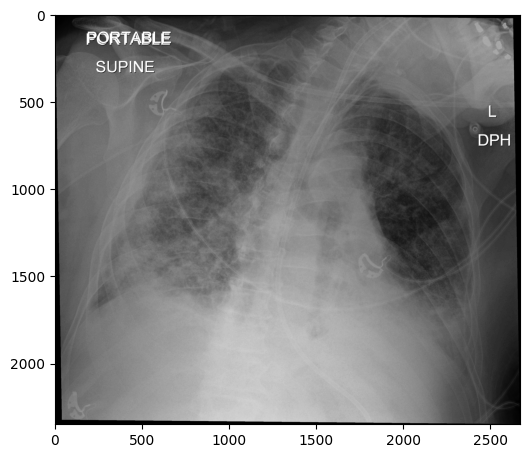

In [36]:
## tell matplotlib to display our images as 6 x 6 inch image, with resolution of 100 dpi
plt.figure(figsize = (6,6), dpi=100) 

## tell matplotlib to display our image, using a gray-scale lookup table.
plt.imshow(dimg.pixel_array, cmap=plt.cm.gray)